# 5 Modeling

## 5.1 Data Source

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# packages for NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# packages required to calculate jaccard similarity
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

# Normalizing data
from sklearn.preprocessing import Normalizer

# regex
import re

# importing non-negative matrix factorization
from sklearn.decomposition import NMF


In [3]:
# function to find similar movies and provide recommendation
def similar_movies(x, data, k=None):
    """The function take a movie and returns [k:optional] similar movies"""
    # if data.index.any(x) == False:
    #     return print('The movie is not in the database')
    
    movies=data.loc[x]
    
    if k == None:        
        movies_rec=movies.sort_values(ascending=False)
    else: 
        movies_rec=movies.sort_values(ascending=False)[0:k]
        
    return movies_rec

## 5.2 Content Based Recommendation System

### 5.2.1 Importing Data

In [ ]:
movies_metadata_small.pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movies_metadata_small.csv')

### 5.2.2 Genre and popularity

Since the genre only based model produced so many movies ranked as one, I will include the average_vote, so if a person watches a popular movie, it will recommend other popular movies in the same genre.

In [ ]:
# remove all columns except genre and vote_average columns
drop_columns=['Unnamed: 0', 'Unnamed: 0.1','imdb_id', 'original_language', 'overview', 'release_date', 'release_year','outlier','spoken_languages_list', 'spoken_languages', 'vote_count', 'genres_list', 'production_companies_list', 'id']
movies_metadata_genre_vote = movies_metadata_small.drop(columns=drop_columns)

In [ ]:
# collecting movie titles for index
movies_index = movies_metadata_genre_vote['title']
movies_metadata_genre_vote = movies_metadata_genre_vote.drop(columns = ['title'])

In [ ]:
movies_metadata_genre_vote.columns

Index(['vote_average', 'Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western'],
      dtype='object')

In [ ]:
movies_metadata_genre_vote.index=movies_index

In [ ]:
movies_metadata_genre_vote.head()

,vote_average,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,History,Mystery,War,Foreign,Music,Documentary,Western
title,,,,,,,,,,,,,,,,,,,
Toy Story,7.7,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Jumanji,6.9,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Grumpier Old Men,6.5,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Waiting to Exhale,6.1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
Father of the Bride Part II,5.7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 5.2.2.1 Normalizing data

Since the vote count data ranges between 1 and 10, I need to normalize the data. normalizing the data will ensure the distance calculations do not put more weight on vote average than the dummy variables.

In [ ]:
# initilize the normalizer
norm = Normalizer()

# fit and transform
norm_fit = norm.fit_transform(movies_metadata_genre_vote)

# creating a data frame
movies_genre_vote_transform = pd.DataFrame(norm_fit, columns = movies_metadata_genre_vote.columns, 
                                          index = movies_metadata_genre_vote.index)
movies_genre_vote_transform.head()

,vote_average,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,History,Mystery,War,Foreign,Music,Documentary,Western
title,,,,,,,,,,,,,,,,,,,
Toy Story,0.975622,0.126704,0.126704,0.126704,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji,0.969909,0.000000,0.000000,0.140566,0.140566,0.140566,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men,0.977140,0.000000,0.150329,0.000000,0.000000,0.000000,0.150329,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale,0.961973,0.000000,0.157700,0.000000,0.000000,0.000000,0.157700,0.1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II,0.984957,0.000000,0.172799,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# remove movies_metadata_genre_vote
del movies_metadata_genre_vote

#### 5.2.2.2 Cosine Similarity

In [ ]:
# calculating cosine similarity
movies_metadata_genre_vote_similarity = cosine_similarity(movies_genre_vote_transform)

In [ ]:
# converting to data frame
movies_metadata_genre_vote_similarity_df = pd. DataFrame(movies_metadata_genre_vote_similarity, index = movies_genre_vote_transform.index,
                                                        columns = movies_genre_vote_transform.index)
movies_metadata_genre_vote_similarity_df.head()

title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,The Final Storm,In a Heartbeat,"Blood, Sweat and Tears",To Be Fat Like Me,Cadet Kelly,The Man with the Rubber Head,The Devilish Tenant,The One-Man Band,Mom,Robin Hood
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.964075,0.972366,0.958503,0.982840,0.944289,0.971115,0.936891,0.930569,0.943668,...,0.858261,0.992997,0.965240,0.963177,0.981995,0.975548,0.973092,0.942726,0.943668,0.933477
Jumanji,0.964075,1.000000,0.947737,0.933026,0.955319,0.938759,0.945621,0.958352,0.949497,0.958742,...,0.853235,0.959385,0.959588,0.960347,0.952457,0.971724,0.969526,0.958102,0.938142,0.928010
Grumpier Old Men,0.972366,0.947737,1.000000,0.987396,0.988418,0.945758,0.999950,0.916312,0.932016,0.945136,...,0.859596,0.985166,0.966742,0.940253,0.987947,0.980096,0.978027,0.944193,0.945136,0.960163
Waiting to Exhale,0.958503,0.933026,0.987396,1.000000,0.974752,0.950901,0.987481,0.929475,0.917550,0.930465,...,0.846254,0.972148,0.974681,0.956008,0.974445,0.966138,0.964264,0.929537,0.953577,0.973360
Father of the Bride Part II,0.982840,0.955319,0.988418,0.974752,1.000000,0.953324,0.987465,0.923642,0.939473,0.952697,...,0.866473,0.977790,0.974476,0.947775,0.999867,0.990688,0.988957,0.951747,0.952697,0.942408


In [ ]:
# removes movies_genre_vote_transform
del movies_genre_vote_transform

In [ ]:
del norm
del norm_fit

#### 5.2.2.3 Finding similar movies

In [ ]:
similar_movies('Toy Story', movies_metadata_genre_vote_similarity_df, 10)

title
Toy Story                            1.000000
One Froggy Evening                   0.999996
Toy Story 3                          0.999996
Rabbit Fire                          0.999996
The Wrong Trousers                   0.999996
A Charlie Brown Christmas            0.999984
There Once Was a Dog                 0.999984
Monsters, Inc.                       0.999984
A Close Shave                        0.999984
Scooby-Doo! and the Samurai Sword    0.999962
Name: Toy Story, dtype: float64

In [ ]:
similar_movies('Toy Story', movies_metadata_genre_vote_similarity_df, 50)

title
Toy Story                                               1.000000
One Froggy Evening                                      0.999996
Toy Story 3                                             0.999996
Rabbit Fire                                             0.999996
The Wrong Trousers                                      0.999996
A Charlie Brown Christmas                               0.999984
There Once Was a Dog                                    0.999984
Monsters, Inc.                                          0.999984
A Close Shave                                           0.999984
Scooby-Doo! and the Samurai Sword                       0.999962
Cosmic Scrat-tastrophe                                  0.999962
Creature Comforts                                       0.999932
Toy Story of Terror!                                    0.999932
Toy Story 2                                             0.999932
Scooby-Doo! Camp Scare                                  0.999932
Banana             

In [ ]:
del movies_metadata_genre_vote_similarity

# remove the last recommendation system
del movies_metadata_genre_vote_similarity_df

#### 5.2.2.4 Genre and Vote Average Summary

The Genre and vote count recommendation did better because it recommended Toy Story 3 in the top 10 similar movies to Toy Story, and it recommended two other Toy Story movies in the top 50. However, there are still a lot of movies with a similarity score close to 1.

### 5.2.3 Genre and Keyword

Although the recommendation system with both genre and average vote count was able to recommend a sequal of Toy Story in the top 10 results, it did miss Toy Story 2, which maybe a result of the lower popularity of the second movie. Also, since it only uses genre and popularity, there are a lot of results to go through. To help the system better recommend sequal and more similar movies, I am adding keywords as a feature. 

Since keywords is stored as a string version of a dictionary, I will first have to convert just the keywords to strings.

#### 5.2.3.1 Importing Data

In [75]:
# importing data
movies_metadata=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movies_metadata_cleaned.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [76]:
# function to find similar movies and provide recommendation
def similar_movies(x, data, k=None):
    """The function take a movie and returns [k:optional] similar movies"""
    # if data.index.any(x) == False:
    #     return print('The movie is not in the database')
    
    movies=data.loc[x]
    
    if k == None:        
        movies_rec=movies.sort_values(ascending=False)
    else: 
        movies_rec=movies.sort_values(ascending=False)[0:k]
        
    return movies_rec

In [77]:
# reducing the set to more popular movies
movies_metadata_small=movies_metadata[movies_metadata['vote_count']>10]
movies_metadata_small.head()

,Unnamed: 0,Unnamed: 0.1,id,imdb_id,original_language,overview,release_date,spoken_languages,title,vote_average,...,Mystery,War,Foreign,Music,Documentary,Western,production_companies_list,spoken_languages_list,release_year,outlier
0,0,0,862,tt0114709,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,...,0,0,0,0,0,0,['Pixar Animation Studios'],['en'],1995,non-outlier
1,1,1,8844,tt0113497,en,When siblings Judy and Peter discover an encha...,1995-12-15,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,...,0,0,0,0,0,0,"['TriStar Pictures', 'Teitler Film', 'Intersco...","['en', 'fr']",1995,non-outlier
2,2,2,15602,tt0113228,en,A family wedding reignites the ancient feud be...,1995-12-22,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,...,0,0,0,0,0,0,"['Warner Bros.', 'Lancaster Gate']",['en'],1995,non-outlier
3,3,3,31357,tt0114885,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,...,0,0,0,0,0,0,['Twentieth Century Fox Film Corporation'],['en'],1995,non-outlier
4,4,4,11862,tt0113041,en,Just when George Banks has recovered from his ...,1995-02-10,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,...,0,0,0,0,0,0,"['Sandollar Productions', 'Touchstone Pictures']",['en'],1995,non-outlier


In [78]:
# removes movies_metadata
del movies_metadata

In [79]:
# importing keywords
keywords=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/keywords_cleaned.csv')
keywords.head()

,Unnamed: 0,Unnamed: 0.1,id,keywords
0,0,0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,1,1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,2,2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,3,3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,4,4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


#### 4.2.3.2 Formatting Data

In [80]:
# dropping unnecessary columns
movies_metadata_small.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
keywords.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

# merging movies_metadata_small with keywords
movies_metadata_genre_keyword=movies_metadata_small.merge(keywords, how='left', on='id')
movies_metadata_genre_keyword.columns

Index(['id', 'imdb_id', 'original_language', 'overview', 'release_date',
       'spoken_languages', 'title', 'vote_average', 'vote_count',
       'genres_list', 'Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western',
       'production_companies_list', 'spoken_languages_list', 'release_year',
       'outlier', 'keywords'],
      dtype='object')

In [81]:
# removes movies_metadata_small and keywords
del keywords
del movies_metadata_small

In [82]:
# removing unnecessary columns from the new data frame
drop_columns=['id', 'imdb_id', 'original_language', 'overview', 'release_date',
       'spoken_languages', 'vote_average', 'vote_count',
       'genres_list', 'production_companies_list', 'spoken_languages_list', 'release_year',
       'outlier']

movies_metadata_genre_keyword.drop(columns=drop_columns, inplace=True)

movies_metadata_genre_keyword.columns

Index(['title', 'Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western',
       'keywords'],
      dtype='object')

In [83]:
del drop_columns

In [84]:
# setting the title as index
movies_index=movies_metadata_genre_keyword['title']
movies_metadata_genre_keyword.index=movies_index

# drop title column
movies_metadata_genre_keyword.drop(columns=['title'], inplace=True)

# checking the results
movies_metadata_genre_keyword.head()

,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,History,Mystery,War,Foreign,Music,Documentary,Western,keywords
title,,,,,,,,,,,,,,,,,,,
Toy Story,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
Jumanji,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
Grumpier Old Men,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
Waiting to Exhale,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
Father of the Bride Part II,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [85]:
del movies_index

#### 4.2.3.3 Extracting Keywords

In [86]:
# inspecting the keywords column
movies_metadata_genre_keyword.loc[:,'keywords']

title
Toy Story                       [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
Jumanji                         [{'id': 10090, 'name': 'board game'}, {'id': 1...
Grumpier Old Men                [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
Waiting to Exhale               [{'id': 818, 'name': 'based on novel'}, {'id':...
Father of the Bride Part II     [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
                                                      ...                        
The Man with the Rubber Head    [{'id': 10124, 'name': 'laboratory'}, {'id': 1...
The Devilish Tenant             [{'id': 11320, 'name': 'tenant'}, {'id': 15480...
The One-Man Band                                                               []
Mom                             [{'id': 155794, 'name': 'physical abuse'}, {'i...
Robin Hood                                                                     []
Name: keywords, Length: 21740, dtype: object

In [87]:
# convert keywords column to a string
movies_metadata_genre_keyword['keywords']=movies_metadata_genre_keyword['keywords'].astype(str)

In [88]:
# function extracts keywords
def extract_keywords(row):
    """This function takes the string text in genres columns and collects the genres into a list"""
    keywords=re.findall(r"'name':\s+'(\w+\s*\w+)'",row)

    words=''
    for number, word in enumerate(keywords):
      if number==0:
        words = str(word)
      else:
        words = words + ", " + str(word)
    return words

#creates a new column keywords_list
movies_metadata_genre_keyword['keywords_list']=movies_metadata_genre_keyword['keywords'].apply(lambda row: extract_keywords(row))

# inspect the results
movies_metadata_genre_keyword['keywords_list']

title
Toy Story                       jealousy, toy, boy, friendship, friends, rival...
Jumanji                         board game, disappearance, new home, recluse, ...
Grumpier Old Men                fishing, best friend, duringcreditsstinger, ol...
Waiting to Exhale               interracial relationship, single mother, divor...
Father of the Bride Part II     baby, midlife crisis, confidence, aging, daugh...
                                                      ...                        
The Man with the Rubber Head    laboratory, mad scientist, disembodied head, s...
The Devilish Tenant                                           tenant, silent film
The One-Man Band                                                                 
Mom                                                physical abuse, sexual assault
Robin Hood                                                                       
Name: keywords_list, Length: 21740, dtype: object

To use the TfidfVectorizer, I will need to convert the list into a string and remove the [] and commas

In [89]:
# drop the keywords column
movies_metadata_genre_keyword.drop(columns=['keywords'], inplace=True)

In [90]:
# convert keywords_list to a string
movies_metadata_genre_keyword['keywords']=movies_metadata_genre_keyword['keywords_list'].astype(str)

In [91]:
movies_metadata_genre_keyword['keywords']=movies_metadata_genre_keyword['keywords'].fillna('')

In [92]:
# check the results
movies_metadata_genre_keyword['keywords']

title
Toy Story                       jealousy, toy, boy, friendship, friends, rival...
Jumanji                         board game, disappearance, new home, recluse, ...
Grumpier Old Men                fishing, best friend, duringcreditsstinger, ol...
Waiting to Exhale               interracial relationship, single mother, divor...
Father of the Bride Part II     baby, midlife crisis, confidence, aging, daugh...
                                                      ...                        
The Man with the Rubber Head    laboratory, mad scientist, disembodied head, s...
The Devilish Tenant                                           tenant, silent film
The One-Man Band                                                                 
Mom                                                physical abuse, sexual assault
Robin Hood                                                                       
Name: keywords, Length: 21740, dtype: object

In [93]:
# drop the keywords_list column
movies_metadata_genre_keyword.drop(columns=['keywords_list'], inplace=True)

#### 4.2.3.4 Creating TfidfVectorizer for Keywords

In [94]:
tfidfvec=TfidfVectorizer(analyzer='word', stop_words='english', max_features=100)

tfidfvec_data=tfidfvec.fit_transform(movies_metadata_genre_keyword['keywords'])

tfidfvec.get_feature_names_out()

array(['aftercreditsstinger', 'agent', 'alien', 'american', 'angeles',
       'animal', 'arts', 'bank', 'biography', 'blood', 'car', 'chase',
       'child', 'christmas', 'comedy', 'crime', 'cult', 'daughter',
       'death', 'detective', 'director', 'dog', 'drug',
       'duringcreditsstinger', 'dystopia', 'england', 'escape', 'family',
       'female', 'fight', 'film', 'friendship', 'gang', 'gangster', 'gay',
       'girl', 'gore', 'gun', 'hero', 'high', 'horror', 'hospital',
       'house', 'identity', 'independent', 'investigation', 'island',
       'kidnapping', 'killer', 'life', 'london', 'los', 'love', 'male',
       'man', 'marriage', 'martial', 'money', 'monster', 'mother',
       'movie', 'murder', 'music', 'musical', 'new', 'noir', 'nudity',
       'paris', 'party', 'police', 'prison', 'prostitute', 'rape',
       'relationship', 'revenge', 'robbery', 'school', 'secret', 'sequel',
       'serial', 'sex', 'sexual', 'soldier', 'space', 'sport', 'suicide',
       'suspense', 't

In [95]:
tfidfvec_data_df=pd.DataFrame(tfidfvec_data.toarray(), columns=tfidfvec.get_feature_names_out())

tfidfvec_data_df.index=movies_metadata_genre_keyword.index

tfidfvec_data_df.head()



,aftercreditsstinger,agent,alien,american,angeles,animal,arts,bank,biography,blood,...,town,train,travel,vampire,violence,war,wedding,woman,york,zombie
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
del tfidfvec
del tfidfvec_data

In [97]:
# removing keyword column, so I can merge it with the tfidfvec data frame
keyword_genre_df = movies_metadata_genre_keyword.drop(columns=['keywords'])

# combining genre and tfidf data for each movie
keyword_genre_df = keyword_genre_df.merge(tfidfvec_data_df, how='left', left_index=True, right_index=True)

keyword_genre_df.head()

,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,...,town,train,travel,vampire,violence,war,wedding,woman,york,zombie
title,,,,,,,,,,,,,,,,,,,,,
#1 Cheerleader Camp,0,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
#Horror,0,0,0,0,0,0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
$5 a Day,0,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
$50K and a Call Girl: A Love Story,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
$9.99,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506789,0.0,0.0


In [98]:
keyword_genre_df.shape

(24260, 118)

In [99]:
del tfidfvec_data_df
del movies_metadata_genre_keyword

Since tfidf creates entries that at between zero and one and the genre data is dummy variables, I do not need to normalize this data.

In [100]:
# ensuring all of the data is less or equal 1.
len(keyword_genre_df.max()<=1)

118

In [101]:
# ensuring all of the data is greater than or equal to 0
len(keyword_genre_df.max()>=0)

118

#### 4.2.3.5 Non-negative Matrix Factorization

When trying to calculate cosine similarity, my system keeps crashing, so I decided to reduce the number of dimensions by using non-negative matrix factorization.

In [102]:
#initating NMF
# nmf=NMF(n_components=10)

In [103]:
# saving movie titles
# movie_names=keyword_genre_df.index

# fitting it to the data
# keyword_genre=nmf.fit_transform(keyword_genre_df)

In [104]:
# creating a data frame and setting the movie titles as the index
# keyword_genre=pd.DataFrame(keyword_genre, index=movie_names)

In [105]:
# deleting the old NMF
# del nmf

In [106]:
# deleting the old keyword_genre_df
# del keyword_genre_df

#### 4.2.3.6 Cosine Similarity

In [107]:
# calculating cosine similarity
genre_keyword_similarity=cosine_similarity(keyword_genre_df)

In [108]:
# saving cosine similarity as a data frame
genre_keyword_similarity_df=pd.DataFrame(genre_keyword_similarity, columns=keyword_genre_df.index, index=keyword_genre_df.index)
genre_keyword_similarity_df.head()

title,#1 Cheerleader Camp,#Horror,$5 a Day,$50K and a Call Girl: A Love Story,$9.99,'71,'Tis the Season for Love,'Twas the Night Before Christmas,(500) Days of Summer,(Dis)Honesty: The Truth About Lies,...,À nos amours,À propos de Nice,Æon Flux,Çalgı Çengi,È arrivato mio fratello,Él,Ödipussi,Üvegtigris,Želary,’Round Midnight
title,,,,,,,,,,,,,,,,,,,,,
#1 Cheerleader Camp,1.000000,0.353553,1.000000,0.707107,0.408248,0.353553,0.0,0.000000,0.707107,0.000000,...,0.408248,0.0,0.000000,0.707107,0.707107,0.408248,0.707107,0.707107,0.500000,0.500000
#Horror,0.353553,1.000000,0.353553,0.500000,0.288675,0.500000,0.0,0.000000,0.250000,0.000000,...,0.288675,0.0,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,0.353553,0.353553
$5 a Day,1.000000,0.353553,1.000000,0.707107,0.408248,0.353553,0.0,0.000000,0.707107,0.000000,...,0.408248,0.0,0.000000,0.707107,0.707107,0.408248,0.707107,0.707107,0.500000,0.500000
$50K and a Call Girl: A Love Story,0.707107,0.500000,0.707107,1.000000,0.577350,0.500000,0.0,0.000000,0.500000,0.000000,...,0.577350,0.0,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,0.707107,0.707107
$9.99,0.408248,0.288675,0.408248,0.577350,1.000000,0.288675,0.0,0.408248,0.288675,0.296119,...,0.333333,0.0,0.135563,0.000000,0.000000,0.333333,0.000000,0.000000,0.408248,0.408248


In [109]:
del keyword_genre_df

In [110]:
# removing genre_keyword_similarity
del genre_keyword_similarity

In [111]:
# deleting movie names
# del movie_names

#### 4.2.3.7 Finding Similar movies

In [112]:
similar_movies('Toy Story', genre_keyword_similarity_df, 20)

title
Toy Story                                           1.000000
Doug's 1st Movie                                    0.931201
Kronk's New Groove                                  0.873742
Saving Santa                                        0.866025
Bon Voyage, Charlie Brown (and Don't Come Back!)    0.866025
Rabbit Fire                                         0.866025
Rabbit Seasoning                                    0.866025
The Bugs Bunny/Road Runner Movie                    0.866025
The Ugly Duckling and Me!                           0.866025
Scooby-Doo Goes Hollywood                           0.866025
Toy Story of Terror!                                0.866025
Mr. Magoo's Christmas Carol                         0.866025
Scooby-Doo! And the Legend of the Vampire           0.866025
Moomins on the Riviera                              0.866025
Scooby-Doo! Camp Scare                              0.866025
Minions: Orientation Day                            0.866025
The Prince and the

In [113]:
similar_movies('Toy Story 2', genre_keyword_similarity_df, 20)

title
Toy Story 2                                  1.000000
Doug's 1st Movie                             0.888281
A Boy Named Charlie Brown                    0.866025
Barbie as The Princess & the Pauper          0.866025
Hop                                          0.866025
The Bugs Bunny/Road Runner Movie             0.866025
Minions: Orientation Day                     0.866025
Open Season 3                                0.866025
The SpongeBob SquarePants Movie              0.866025
Hoodwinked Too! Hood VS. Evil                0.866025
The Ugly Duckling and Me!                    0.866025
Rabbit Fire                                  0.866025
Toy Story of Terror!                         0.866025
Scooby-Doo! and the Loch Ness Monster        0.866025
Bugs Bunny's 3rd Movie: 1001 Rabbit Tales    0.866025
Big Top Scooby-Doo!                          0.866025
The Prince and the Pauper                    0.866025
Dug's Special Mission                        0.866025
Rabbit Seasoning      

In [115]:
genre_keyword_similarity_df.loc['Toy Story',['Toy Story 2', 'Toy Story 3', 'Toy Story of Terror!']]

title
Toy Story 2             0.850227
Toy Story 3             0.750000
Toy Story of Terror!    0.866025
Name: Toy Story, dtype: float64

In [116]:
del genre_keyword_similarity_df 

#### 4.2 Genre and Keyword Summary

The recommendation system does return Toy Story of Terror for both Toy Story and Toy Story 2. Toy Story has a score of .85, .75, and .87 with Toy Story 2, Toy Story3, and Toy Story of Terror, respectively. Thus, the system does give out reasonable scores; however, it seems like the system is still scoring more based on genre; which is why there are many movies with scores close to 1. 

## 5.3 Collabrative Based Recommendation System

For the collabrative filtering, I will only use the same movies I used for the content based model, so the models are comparable.

### 5.3.1 Importing Data

In [5]:
# collecting ratings data
ratings=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/ratings_cleaned.csv')

In [ ]:
# collecting movie data
metadata=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movies_metadata_small.csv')

In [ ]:
ratings.head()

,Unnamed: 0,Unnamed: 0.1,userId,movieId,rating
0,0,0,1,110,1.0
1,1,1,1,147,4.5
2,2,2,1,858,5.0
3,3,3,1,1221,5.0
4,4,4,1,1246,5.0


In [ ]:
metadata.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,imdb_id,original_language,overview,release_date,spoken_languages,title,...,Mystery,War,Foreign,Music,Documentary,Western,production_companies_list,spoken_languages_list,release_year,outlier
0,0,0,0,862,tt0114709,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,...,0,0,0,0,0,0,['Pixar Animation Studios'],['en'],1995,non-outlier
1,1,1,1,8844,tt0113497,en,When siblings Judy and Peter discover an encha...,1995-12-15,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,...,0,0,0,0,0,0,"['TriStar Pictures', 'Teitler Film', 'Intersco...","['en', 'fr']",1995,non-outlier
2,2,2,2,15602,tt0113228,en,A family wedding reignites the ancient feud be...,1995-12-22,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,...,0,0,0,0,0,0,"['Warner Bros.', 'Lancaster Gate']",['en'],1995,non-outlier
3,3,3,3,31357,tt0114885,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,...,0,0,0,0,0,0,['Twentieth Century Fox Film Corporation'],['en'],1995,non-outlier
4,4,4,4,11862,tt0113041,en,Just when George Banks has recovered from his ...,1995-02-10,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,...,0,0,0,0,0,0,"['Sandollar Productions', 'Touchstone Pictures']",['en'],1995,non-outlier


### 5.3.2 Formatting

#### 5.3.2.1 Formatting Movie Data

I am creating a user movie rating matrix. For collaborative filtering, I won't use any of the movie metadata; however, I am using the metadata to get the movie titles used in the ratings dataset.

In [ ]:
# selecting only movie id and title
movies=metadata[['id','title']]
movies.head()

,id,title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [ ]:
# deleting metadata
del metadata

In [ ]:
# find the total number of movies.shape

In [ ]:
# checking data types
movies.dtypes

id        int64
title    object
dtype: object

In [ ]:
# convert id to string
movies['id']=movies['id'].astype(str)

# making sure it worked
movies.dtypes

id       object
title    object
dtype: object

In [ ]:
# checking for unique values
movies['id'].unique()

array(['862', '8844', '15602', ..., '49280', '404604', '30840'],
      dtype=object)

all movie id's appear to be unique. Next, I will check for missing values. Since missing values may be encoed as empty quotes, I will check to see if there are any entries that are empty quotes.

In [ ]:
movies['id'].isna().any()

False

In [ ]:
movies[movies['id']=='']

,id,title


#### 5.3.2.2 Formating Ratings data

In [ ]:
ratings.head()

,Unnamed: 0,Unnamed: 0.1,userId,movieId,rating
0,0,0,1,110,1.0
1,1,1,1,147,4.5
2,2,2,1,858,5.0
3,3,3,1,1221,5.0
4,4,4,1,1246,5.0


In [ ]:
# Need to remove the two unnamed columns
ratings.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [ ]:
ratings.shape

(26024289, 3)

In [ ]:
# checking data types
ratings.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

In [ ]:
# converting userid and movie id into string
ratings['userId']=ratings['userId'].astype(str)
ratings['movieId']=ratings['movieId'].astype(str)

#checking the results
ratings.dtypes

userId      object
movieId     object
rating     float64
dtype: object

In [ ]:
# seeing how many users there are
len(ratings['userId'].unique())

270896

In [ ]:
# seeing how many movies are rated
len(ratings['movieId'].unique())

45115

In [ ]:
# number of movies rated by each user
rating_pivot=ratings.groupby('userId')['rating'].count()
rating_pivot.head()

userId
1        27
10       13
100       3
1000      6
10000    10
Name: rating, dtype: int64

In [ ]:
# rating count distribution
rating_pivot.describe()

count    270896.000000
mean         96.067454
std         205.719606
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max       18276.000000
Name: rating, dtype: float64

There are 26,024,289 ratings given by 270,896 user on 45,115 movies

#### 5.3.2.3 Merging ratings and movies

In [ ]:
movie_ratings=ratings.merge(movies, how='inner',left_on='movieId', right_on='id')
movie_ratings.head()

,userId,movieId,rating,id,title
0,1,110,1.0,110,Three Colors: Red
1,11,110,3.5,110,Three Colors: Red
2,22,110,5.0,110,Three Colors: Red
3,24,110,5.0,110,Three Colors: Red
4,29,110,3.0,110,Three Colors: Red


In [ ]:
del movies
del ratings

In [ ]:
# removing movieId and id column 
movie_ratings.drop(columns=['movieId', 'id'], inplace=True)

In [ ]:
# looking at number of ratings
movie_ratings.shape

(9939845, 3)

In [ ]:
# number of users
len(movie_ratings['userId'].unique())

264541

In [ ]:
# number of movies
len(movie_ratings['title'].unique())

3993

After merging the data, there are 9,939,845 ratings given by 264,541 users over 3,993 movies.  

In [ ]:
# ratings distribution
movie_ratings['rating'].describe()

count    9.939845e+06
mean     3.536421e+00
std      1.068440e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [ ]:
rating_pivot=movie_ratings.groupby('userId')['rating'].count()
rating_pivot.describe()

count    264541.000000
mean         37.573930
std          65.755042
min           1.000000
25%           6.000000
50%          14.000000
75%          40.000000
max        2315.000000
Name: rating, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


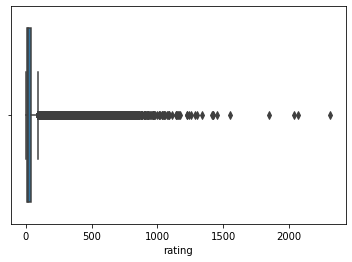

In [ ]:
sns.boxplot(rating_pivot)
plt.show()

In [ ]:
rating_pivot=movie_ratings.groupby('userId')['rating'].mean()
rating_pivot.sort_values(ascending=False).head()

userId
232991    5.0
12250     5.0
204176    5.0
26848     5.0
215167    5.0
Name: rating, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


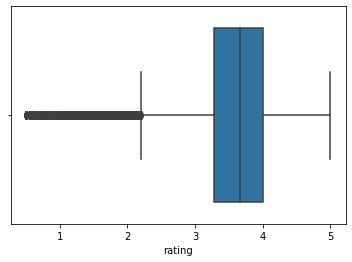

In [ ]:
sns.boxplot(rating_pivot)
plt.show()

There is at least one user who has rated 2,315 movies while there are some users who have only rated 1 movie.

In [ ]:
del rating_pivot

#### 5.3.2.4 Saving the merged data set

In [ ]:
movie_ratings.to_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movie_ratings.csv')

In [ ]:
del movie_ratings

### 5.3.3 user-item matrix

#### 5.3.3.1 Importing Data

In [4]:
movie_ratings=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/movie_recommendation_system/data/movie_ratings.csv')

In [5]:
movie_ratings.head()

,Unnamed: 0,userId,rating,title
0,0,1,1.0,Three Colors: Red
1,1,11,3.5,Three Colors: Red
2,2,22,5.0,Three Colors: Red
3,3,24,5.0,Three Colors: Red
4,4,29,3.0,Three Colors: Red


#### 5.3.3.2 Reshaping the data frame

In [6]:
# dropping the Unnamed:0 column
movie_ratings.drop(columns=['Unnamed: 0'], inplace=True)
movie_ratings.head()

,userId,rating,title
0,1,1.0,Three Colors: Red
1,11,3.5,Three Colors: Red
2,22,5.0,Three Colors: Red
3,24,5.0,Three Colors: Red
4,29,3.0,Three Colors: Red


In [7]:
np.random.seed=42
sample=np.random.randint(0,movie_ratings.shape[0], size=int(movie_ratings.shape[0]/100))
len(sample)

99398

In [8]:
# reducing the number of reviews 
movie_ratings_small=movie_ratings.iloc[sample,:]
movie_ratings_small.shape

(99398, 3)

In [9]:
del movie_ratings

In [10]:
movie_ratings_small.head()

,userId,rating,title
2533069,268649,4.0,Rain Man
1283408,260932,4.0,The Man with the Golden Arm
2285566,129766,5.0,And Then There Were None
9643245,165989,3.0,Soldier of Orange
7829116,216413,3.5,Secret Agent


In [11]:
# creating the user_item matrix
user_item=pd.pivot_table(movie_ratings_small, index='userId', columns='title', values='rating', fill_value=np.nan)


In [12]:
del movie_ratings_small

In [15]:
# checking the size of the matrix
user_item.shape

(61310, 2544)

In [14]:
# first few rows
user_item.head()

title,$5 a Day,'Twas the Night Before Christmas,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,127 Hours,13 Tzameti,...,Zatoichi,Zazie dans le métro,Zero for Conduct,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,eXistenZ,xXx,À nos amours,Ödipussi
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 5.3.3.3 dealing with missing value

In [19]:
# finding how many missing ratings
user_item.isna().sum()

title
$5 a Day                                61309
'Twas the Night Before Christmas        61305
00 Schneider - Jagd auf Nihil Baxter    61307
10 Items or Less                        61287
10 Things I Hate About You              61292
                                        ...  
Zombie Holocaust                        61308
eXistenZ                                61289
xXx                                     61233
À nos amours                            61294
Ödipussi                                61306
Length: 2544, dtype: int64

In [20]:
#determining the sparsity of the matrix
(user_item.isna().sum().sum())/(user_item.shape[0]*user_item.shape[1])

0.99936611959636